# Greenspace metrics at scales 100m, 300m, and 500m

In [1]:
import pandas as pd
import scipy as sp
import numpy as np
import rasterio
import os
import geopandas as gpd
import random
from scipy.ndimage import convolve
from rasterio.transform import from_origin
from rasterio.plot import show
from shapely.geometry import box, Point, Polygon
from osgeo import gdal
%matplotlib inline

## NDVI input map

In [2]:
# data dir
data_dir = r"thesis_project/data"
fp = os.path.join(data_dir, "CR_NDVI.TIF")

# open the file
ndvi_input_raster = rasterio.open(fp)

# check type of the variable 'raster'
type(ndvi_input_raster)

rasterio.io.DatasetReader

In [3]:
# check metadata for the whole raster dataset
ndvi_input_raster.meta

{'driver': 'GTiff',
 'dtype': 'float32',
 'nodata': -3.3999999521443642e+38,
 'width': 7443,
 'height': 5987,
 'count': 1,
 'crs': CRS.from_epsg(27700),
 'transform': Affine(10.0, 0.0, 341660.6724,
        0.0, -10.0, 431034.6389)}

In [4]:
# read the raster band as separate variable
ndvi_input = ndvi_input_raster.read(1)
type(ndvi_input)

numpy.ndarray

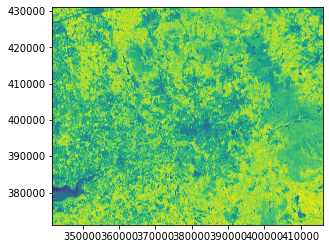

<AxesSubplot:>

In [5]:
# plot input NDVI
show(ndvi_input_raster, 1)

## Focal statistics at 100m

In [9]:
# design kernel at a 100m scale
scale_100 = np.ones((21, 21))
scale_100.shape

(21, 21)

In [10]:
# convolve NDVI input with kernel at 100m (equivalent to average operation)
ndvi_output_100 = convolve(ndvi_input, scale_100) / np.sum(scale_100) # mode=reflect to extend input beyond its boundaries
ndvi_output_100.shape

(5987, 7443)

## NDVI output layer

In [15]:
# convert NDVI output to raster image
transform = from_origin(341660.6724, 431034.6389, 10.0, -10.0)

new_dataset = rasterio.open('thesis_project/output/ndvi_output_100.tif', 'w', driver='GTiff',
                            height = ndvi_output_100.shape[0], width = ndvi_output_100.shape[1],
                            count=1, dtype=str(ndvi_output_100.dtype),
                            crs='+proj=tmerc +lat_0=49 +lon_0=-2 +k=0.9996012717 +x_0=400000 +y_0=-100000 +ellps=airy +datum=OSGB36 +units=m +no_defs',
                            transform=transform)

new_dataset.write(ndvi_output_100, 1)
new_dataset.close()

In [17]:
# output layer metadata
src.meta

{'driver': 'GTiff',
 'dtype': 'float32',
 'nodata': None,
 'width': 7443,
 'height': 5987,
 'count': 1,
 'crs': CRS.from_epsg(27700),
 'transform': Affine(10.0, 0.0, 341660.6724,
        0.0, 10.0, 431034.6389)}

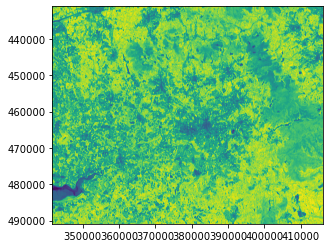

<AxesSubplot:>

In [16]:
# NDVI layer output at 100m
src = rasterio.open("thesis_project/output/ndvi_output_100.tif")
show(src, 1)

## Extract raster values at point locations

In [12]:
# extract raster bounds (later input to create the polygon)
bounds = src.bounds
bounds

BoundingBox(left=341660.6724, bottom=490904.6389, right=416090.6724, top=431034.6389)

In [13]:
# creating shapely polygon from raster boundaries (later input to generate_random function)
polygon_geom = Polygon([[341660.6724,490904.6389],
                        [341660.6724,431034.6389],
                        [416090.672,431034.6389],
                        [416090.672,490904.639],
                        [341660.6724, 490904.6389]])
type(polygon_geom)

shapely.geometry.polygon.Polygon

In [14]:
# function to generate random point coordinates within raster bounds
def generate_random(number, polygon):
    points = []
    minx, miny, maxx, maxy = polygon.bounds
    while len(points) < number:
        pnt = Point(random.uniform(minx, maxx), random.uniform(miny, maxy))
        if polygon.contains(pnt):
            points.append(pnt)
    return points

### Sample 10000 point locations within the extent of raster image

In [15]:
# sample 10000 random point locations
ndvi_100_sample = generate_random(10000, polygon_geom) # need to set seed for reproducibility
print(ndvi_100_sample[3])

POINT (382368.84860842506 463169.6695402028)


In [16]:
# convert list of point geometries to geodataframe
df = pd.DataFrame(ndvi_100_sample, columns=['geometry'])
gdf = gpd.GeoDataFrame(df, geometry='geometry', crs = 'epsg:27700')
#type(gdf)
gdf.head()                      


/Applications/anaconda3/envs/ssml/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


,geometry
0,POINT (403349.017 439048.224)
1,POINT (395262.287 476636.748)
2,POINT (357970.908 438384.299)
3,POINT (382368.849 463169.670)
4,POINT (341713.172 439032.868)


In [17]:
# extract point coordinates from point geometry
point_coords = []
for index, row in gdf.iterrows():
     for pt in list(row['geometry'].coords): 
        point_coords.append(pt)
#print(point_coords)

# add point coordinates to geodataframe
gdf['point_coordinates'] = point_coords
gdf.head()

,geometry,point_coordinates
0,POINT (403349.017 439048.224),"(403349.0170858772, 439048.22445225075)"
1,POINT (395262.287 476636.748),"(395262.28734401753, 476636.7475073408)"
2,POINT (357970.908 438384.299),"(357970.908148411, 438384.298587637)"
3,POINT (382368.849 463169.670),"(382368.84860842506, 463169.6695402028)"
4,POINT (341713.172 439032.868),"(341713.1723745729, 439032.86803836375)"


## Geodataframe including NDVI values at 100m and point coordinates

In [19]:
# open the raster and store metadata
src = rasterio.open("thesis_project/output/ndvi_output_100.tif")

# sample the raster at every point location and store values in DataFrame
gdf['NDVI_100'] = [x[0] for x in src.sample(gdf.point_coordinates)]
gdf.head()

,geometry,point_coordinates,NDVI_100
0,POINT (403349.017 439048.224),"(403349.0170858772, 439048.22445225075)",0.712121
1,POINT (395262.287 476636.748),"(395262.28734401753, 476636.7475073408)",0.437401
2,POINT (357970.908 438384.299),"(357970.908148411, 438384.298587637)",0.562012
3,POINT (382368.849 463169.670),"(382368.84860842506, 463169.6695402028)",0.456313
4,POINT (341713.172 439032.868),"(341713.1723745729, 439032.86803836375)",0.251842


In [22]:
# type of dataframe
type(gdf)

geopandas.geodataframe.GeoDataFrame

### How to directly convert raster image to point shapefile

In [ ]:
# convert raster to point shapefile
filename='thesis_project/output/ndvi_output_100'
inDs = gdal.Open('{}.tif'.format(filename))
outDs = gdal.Translate('{}.xyz'.format(filename), inDs, format='XYZ', creationOptions=["ADD_HEADER_LINE=YES"])
outDs = None
try:
    os.remove('{}.csv'.format(filename))
except OSError:
    pass
os.rename('{}.xyz'.format(filename), '{}.csv'.format(filename))
os.system('ogr2ogr -f "ESRI Shapefile" -oo X_POSSIBLE_NAMES=X* -oo Y_POSSIBLE_NAMES=Y* -oo KEEP_GEOM_COLUMNS=NO {0}.shp {0}.csv'.format(filename))

In [ ]:
len(gdf_ndvi_100)

In [ ]:
# randomly sample 10000 point locations
gdf_ndvi_100 = gdf_ndvi_100.sample(n = 10000)
gdf_ndvi_100 = gdf_ndvi_100.reset_index(drop=True)
gdf_ndvi_100.head()

In [ ]:
# plot gpd
#gdf_ndvi_100.plot()
type(gdf_ndvi_100)

In [ ]:
# save gpd into shapefile
gdf_ndvi_100.to_file(driver = 'ESRI Shapefile', filename= "thesis_project/output/gdf_ndvi_100_sample.shp")


### Draft

In [ ]:
# Step 1: Get input %Greenness
# data dir
#data_dir = r"thesis_project/data"
fp_green = os.path.join(data_dir, "GreenNoGreenRes.TIF")

# open the file:
green_input_raster = rasterio.open(fp_green)

# check type of the variable 'raster'
type(green_input_raster)

In [ ]:
# All Metadata for the whole raster dataset
green_input_raster.meta

In [ ]:
# create NDVI layers at three different scales (100m, 300m, and 500m)
scales = [21, 61, 101]
#scales = [21]

#ndvi_outputs = []
greenspace_dfs = []

for scale in scales:
    
    kernel = np.ones((scale, scale)) # build kernel 
    ndvi_output = (convolve(ndvi_input_arr, kernel) / np.sum(kernel)).ravel() # convert to 1d array
    greenspace_df = pd.DataFrame(ndvi_output, columns=['NDVI']) # create df
    greenspace_dfs.append(greenspace_df) # append to df list

#    ndvi_outputs.append(ndvi_output)
    
#print(len(ndvi_outputs))
print(len(greenspace_dfs))

In [ ]:
# data frame NDVI at 100m
greenspace_df_100 = greenspace_dfs[0]
greenspace_df_100.head()

In [ ]:
# data frame NDVI at 300m
greenspace_df_300 = greenspace_dfs[1]
greenspace_df_300.head()

In [ ]:
# data frame NDVI at 500m
greenspace_df_500 = greenspace_dfs[2]
greenspace_df_500.head()

In [ ]:
ndvi_output_100.shape

In [ ]:
# check sum of kernel (denominator of average operation)
np.sum(scale_100)

In [ ]:
# output map of averaged neighbour
#output_map_100
ndvi_output_100.shape

In [ ]:
ndvi_output_100_1d = ndvi_output_100.ravel()
ndvi_output_100_1d.shape

In [ ]:
# randomly sample 1000 points from 2d array
np.random.seed(1234) #set seed
ndvi_points_100 = np.random.choice(ndvi_output_100.ravel(), 1000 ,replace=False)
ndvi_points_100

5. Store NDVI values for 1000 points into a df

In [ ]:
# creating a df from array
greenspace_metrics_100 = pd.DataFrame(ndvi_points_100, columns=['NDVI'])
#greenspace_metrics_100.head()
greenspace_metrics_100

Here, repeat again the same process but with %greenness

6. Read %Greenness input file

In [ ]:
# reading raster file using gdal
green_input_map = gdal.Open("thesis_project/data/GreenNoGreenRes.tif")

7. Applying focal statistics to %greenness input map at 100m scale

In [ ]:
# convert input map to array
green_input_arr = np.array(green_input_map.GetRasterBand(1).ReadAsArray())
#green_input_arr
green_input_arr.shape

In [ ]:
# fix kernel shape to 100m scale (21x21)
scale_100 = np.ones((21, 21))
#scale_100
scale_100.shape

In [ ]:
# convolve greenness input map with kernel 100m (equivalent to percentage operation)
green_output_100 = convolve(green_input_arr, scale_100) / np.sum(scale_100) # mode=reflect to extend input beyond its boundaries


8. Output layer averaged at 100m scale

In [ ]:
# greenness output map after performing focal statistics
green_output_100
#green_output_100.shape

10. Store %greenness values for 1000 points into a df

In [ ]:
# adding values to data frame
greenspace_metrics_100['%Greenness'] = green_points_100
#greenspace_metrics_100.head()
greenspace_metrics_100

9. Sample 1000 points and extract %greenness values

In [ ]:
# randomly sample 1000 points
np.random.seed(2345) #set seed
green_points_100 = np.random.choice(green_output_100.ravel(), 1000 ,replace=False)
green_points_100